In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

print(X.shape)
X.head()


(1460, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [115]:
def missingvalueinfo(df):
    total=df.isnull().sum().sort_values(ascending=False)
    percent=total/len(df)*100
    temp=pd.concat([total, percent], axis=1, keys=['Total', '%'])
    return temp.loc[(temp['%']>5)]
    
most_missing = missingvalueinfo(data)
most_missing

,Total,%
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


In [116]:
data=data.drop(columns=['PoolQC', 'MiscFeature','Alley', 'Fence'], axis=1)

In [117]:
#magical seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=98987)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

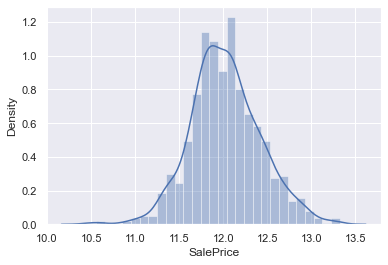

In [118]:
sns.distplot(y_train)

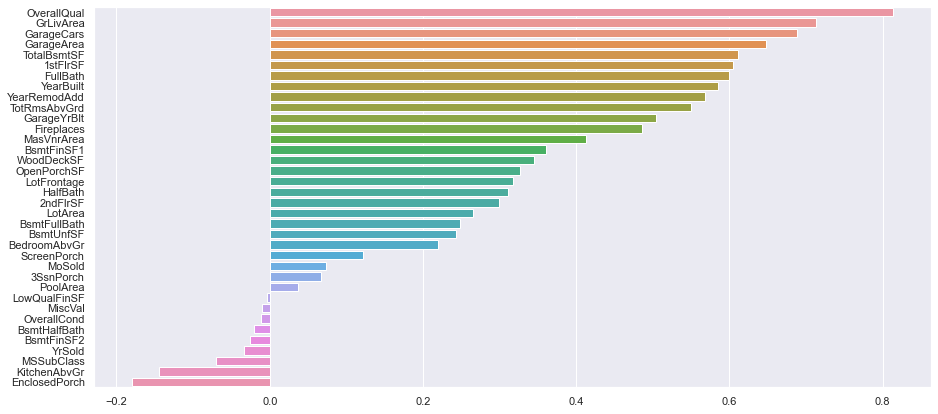

In [119]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()

numeric_features = numeric_data.columns

X_train_filled = X_train.fillna(numeric_data_mean)
X_test_filled = X_test.fillna(numeric_data_mean)

correlations = X_train_filled[numeric_features].corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 7)

<h2>Train on numeric data only</h2>

In [120]:
dtrain_matrix = xgb.DMatrix(numeric_data, label=y_train)

In [121]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dtrain_matrix, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.384388,0.003443,10.384393,0.008030
1,9.350517,0.003103,9.350522,0.008371
2,8.420057,0.002798,8.420062,0.008677
3,7.582699,0.002524,7.582704,0.008953
4,6.829170,0.002281,6.829174,0.009201


In [122]:
from sklearn.preprocessing import LabelEncoder

categorical = X_train_filled.select_dtypes(include='object')
categorical.shape

(1022, 43)

In [123]:
enc = X_train_filled.drop(categorical.columns.values, axis = 1)
enc = pd.concat([enc, pd.get_dummies(categorical)], axis=1)
print(enc.shape)
enc.head()

(1022, 280)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
597,120,53.000000,3922,7,5,2006,2007,72.0,0,0,...,0,1,0,0,0,0,0,0,0,1
239,50,52.000000,8741,6,4,1945,1950,0.0,94,0,...,0,0,0,1,0,0,0,0,1,0
212,60,72.000000,8640,7,5,2009,2009,0.0,822,0,...,0,1,0,0,0,0,0,0,0,1
1155,20,90.000000,10768,5,8,1976,2004,0.0,1157,0,...,0,0,0,1,0,0,0,0,1,0
384,60,70.841121,53107,6,5,1992,1992,0.0,985,0,...,0,0,0,1,0,0,0,0,1,0


In [126]:
dtrain_matrix_enc = xgb.DMatrix(enc, label=y_train)

params = {"objective":"reg:squarederror", 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dtrain_matrix_enc, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.384388,0.003443,10.384393,0.008030
1,9.350517,0.003103,9.350522,0.008371
2,8.420057,0.002798,8.420062,0.008677
3,7.582699,0.002524,7.582704,0.008953
4,6.829170,0.002281,6.829174,0.009201
